In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from scipy import signal
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def percent_scaling(series):
    return (series / 100)

def cpu_scaling(series):
    return (series * 4 / 100)

def single_cpu_scaling(series):
    return (((series - 100) * (-1)) / 100)

def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

k = 251
latchup_start = 50000

In [3]:
def preprocess_df(df):
    df['cache_hit_rate_0'] = (df['cache_hit_0'] - df['cache_miss_0']) / df['cache_hit_0']
    df['cache_hit_rate_1'] = (df['cache_hit_0'] - df['cache_miss_1']) / df['cache_hit_1']
    df['cache_hit_rate_2'] = (df['cache_hit_0'] - df['cache_miss_2']) / df['cache_hit_2']
    df['cache_hit_rate_3'] = (df['cache_hit_0'] - df['cache_miss_3']) / df['cache_hit_3']
    
    df['br_miss_rate_0'] = df['br_miss_0'] / df['br_insns_0']
    df['br_miss_rate_1'] = df['br_miss_1'] / df['br_insns_1']
    df['br_miss_rate_2'] = df['br_miss_2'] / df['br_insns_2']
    df['br_miss_rate_3'] = df['br_miss_3'] / df['br_insns_3']
    
    df['insns_0_norm'] = df['insns_0'] / (df['time'] - df['time'].shift())
    df['insns_1_norm'] = df['insns_1'] / (df['time'] - df['time'].shift())
    df['insns_2_norm'] = df['insns_2'] / (df['time'] - df['time'].shift())
    df['insns_3_norm'] = df['insns_3'] / (df['time'] - df['time'].shift())
    
    df['cycles_0_norm'] = df['cpu_cycles_0'] / (df['time'] - df['time'].shift())
    df['cycles_1_norm'] = df['cpu_cycles_1'] / (df['time'] - df['time'].shift())
    df['cycles_2_norm'] = df['cpu_cycles_2'] / (df['time'] - df['time'].shift())
    df['cycles_3_norm'] = df['cpu_cycles_3'] / (df['time'] - df['time'].shift())
    
    df['bus_cycles_0_norm'] = df['bus_cycles_0'] / (df['time'] - df['time'].shift())
    df['bus_cycles_1_norm'] = df['bus_cycles_1'] / (df['time'] - df['time'].shift())
    df['bus_cycles_2_norm'] = df['bus_cycles_2'] / (df['time'] - df['time'].shift())
    df['bus_cycles_3_norm'] = df['bus_cycles_3'] / (df['time'] - df['time'].shift())

    df['rd_ios_norm'] = df['rd_ios'] * 1000 / (df['time'] - df['time'].shift())
    df['wr_ios_norm'] = df['wr_ios'] * 1000 / (df['time'] - df['time'].shift())

    df['curr_filt'] = df['current'].rolling(window=k, center=True, min_periods=1).min()
    
    df.drop(df.tail(k//2).index,inplace=True)
    df.drop(df.head(k//2).index,inplace=True)

    return df

In [4]:
def detect_latchup(df, start):
    over_count = 0
    under_count = 0
    end_time = latchup_df.loc[start, 'time'] + 3000000

    for row, entry in df.iterrows():
        if entry['time'] > end_time:
            break

        if entry['curr_pred_min'] < entry['curr_filt']:
            over_count += 1
        elif entry['curr_pred_min'] > entry['curr_filt']:
            under_count += 1


    if over_count / (under_count + over_count) > 0.84:
        return (True, over_count, under_count)
    else:
        return (False, over_count, under_count)

In [5]:
with open("model.pkl", "rb") as f:
    model = pickle.load(f)

model

LinearRegression(n_jobs=8)

In [29]:
latchup_df = pd.read_csv('../results/disk-idle.csv')
latchup_df.loc[latchup_start:,'current'] += 0.08

latchup_df = preprocess_df(latchup_df)

X_test = latchup_df[['insns_0_norm', 'insns_1_norm', 'insns_2_norm', 'insns_3_norm',
                     'bus_cycles_0_norm', 'bus_cycles_1_norm', 'bus_cycles_2_norm', 'bus_cycles_3_norm',
                     'br_miss_rate_0', 'br_miss_rate_1', 'br_miss_rate_2', 'br_miss_rate_3',
                     'rd_ios_norm','wr_ios_norm',
                     'freq_0', 'freq_1', 'freq_2', 'freq_3',
                     'cache_hit_rate_0', 'cache_hit_rate_1', 'cache_hit_rate_2', 'cache_hit_rate_3']]
Y_test = latchup_df['curr_filt']
latchup_df['curr_pred'] = model.predict(X_test)

latchup_df['curr_pred_min'] = latchup_df['curr_pred'].rolling(window=k, center=True, min_periods=1).min()

Text(0, 0.5, 'Current (Amperes)')

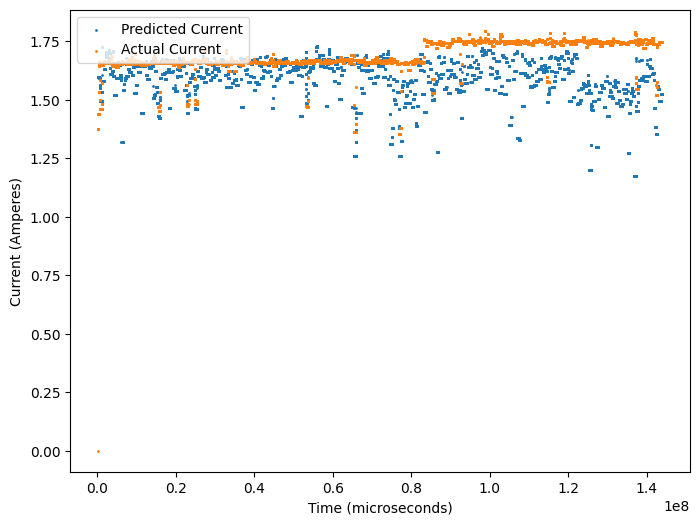

In [30]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

plt.scatter(latchup_df['time'], latchup_df['curr_pred_min'], label='predicted', s=1)
plt.scatter(latchup_df['time'], latchup_df['curr_filt'], label='actual', s=1)
plt.legend(['Predicted Current', 'Actual Current'], loc='upper left')
ax.set_xlabel("Time (microseconds)")
ax.set_ylabel("Current (Amperes)")

In [31]:
detect_latchup(latchup_df, latchup_start)

(True, 43849, 7825)

In [32]:
errs = []
for i in range(1000, latchup_start, 300):
    if len(errs) > 0 and latchup_df.loc[errs[-1][0], 'time'] + 300000 > latchup_df.loc[i, 'time']:
        continue

    is_latchup, over_count, under_count = detect_latchup(latchup_df, i)
    if is_latchup:
        errs.append((i, over_count, under_count))

len(errs)/len(range(1000, latchup_start, 300))

0.09146341463414634

In [33]:
rick_df = pd.read_csv('../results/disk-rick.csv')

rick_df = preprocess_df(rick_df)

X_test = rick_df[['insns_0_norm', 'insns_1_norm', 'insns_2_norm', 'insns_3_norm',
                     'bus_cycles_0_norm', 'bus_cycles_1_norm', 'bus_cycles_2_norm', 'bus_cycles_3_norm',
                     'br_miss_rate_0', 'br_miss_rate_1', 'br_miss_rate_2', 'br_miss_rate_3',
                     'rd_ios_norm','wr_ios_norm',
                     'freq_0', 'freq_1', 'freq_2', 'freq_3',
                     'cache_hit_rate_0', 'cache_hit_rate_1', 'cache_hit_rate_2', 'cache_hit_rate_3']]
Y_test = rick_df['curr_filt']
rick_df['curr_pred'] = model.predict(X_test)

rick_df['curr_pred_min'] = rick_df['curr_pred'].rolling(window=k, center=True, min_periods=1).min()
rick_df.reset_index(drop=True, inplace=True)

Text(0, 0.5, 'Current (Amperes)')

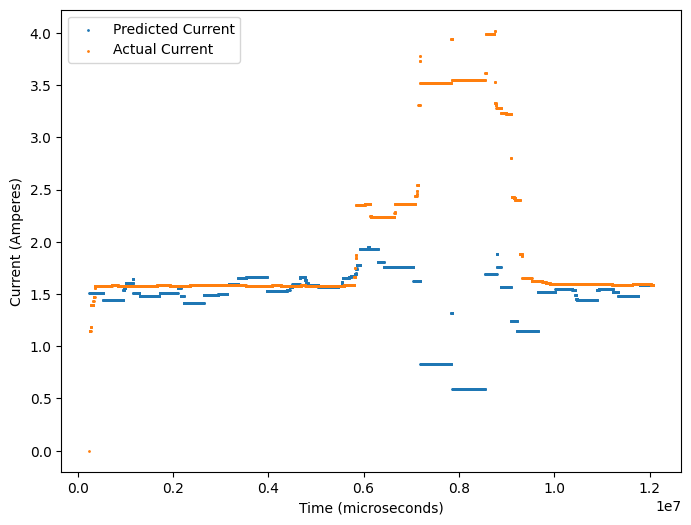

In [34]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

plt.scatter(rick_df['time'], rick_df['curr_pred_min'], label='predicted', s=1)
plt.scatter(rick_df['time'], rick_df['curr_filt'], label='actual', s=1)
plt.legend(['Predicted Current', 'Actual Current'], loc='upper left')
ax.set_xlabel("Time (microseconds)")
ax.set_ylabel("Current (Amperes)")

In [42]:
errs = []
for i in range(150, len(rick_df), 300):
    is_latchup, over_count, under_count = detect_latchup(rick_df, i)
    if is_latchup:
        errs.append((i, over_count, under_count))

len(errs)/len(range(1000, len(rick_df), 300))

0.05263157894736842